In [1]:
from selenium import webdriver
import pandas as pd
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
import seaborn as sns

### 1、二手房网数据爬取-北京昌平霍营

In [2]:
driver=webdriver.Edge()
#北京昌平霍营的网址
url="https://esf.fang.com/house-a012-b02697/"
driver.get(url)

In [3]:
string_list=[]
#在每一页跑循环，把文本分别爬下来，因为一共只有7页，所以循环7次即可
for page in range(1,8):
    url = f"https://esf.fang.com/house-a012-b02697/i{page+30}/"
    table =driver.find_element('class name','shop_list.shop_list_4')
    dls = table.find_elements(By.TAG_NAME, 'dl')
    data = []
    
    for dl in dls:
        cells = dl.find_elements(By.TAG_NAME, 'dd')
        if cells:
            dl_data = [cell.text for cell in cells]
            data.append(dl_data)
    df = pd.DataFrame(data)
    string_list.append(df)

In [4]:
string_list2 = string_list[0]

In [5]:
#处理文本数据，列入DataFrame里面。
#因为有些有双重验真，导致用\n分割会出现问题，所以先替换后分割
string_list2[0] = [s.replace("\n双重验真", "_双重验真", 1) for s in string_list2[0]]

#拆分数据并拼到一个DataFrame里面
df1=string_list2[0].str.split('\n',expand=True)
df2=string_list2[1].str.split('\n',expand=True)
df2.columns = ['总价(万)','单位价格(元/㎡)']
info1 = pd.concat([df1,df2],axis=1)

In [6]:
#去除单位，把str格式换成float（因为有一个有小数点）
info1['总价(万)'] = info1['总价(万)'].apply(lambda x:x[:-1])
info1['单位价格(元/㎡)'] = info1['单位价格(元/㎡)'].apply(lambda x:x[:-3])
info1[['总价(万)','单位价格(元/㎡)']]=info1[['总价(万)','单位价格(元/㎡)']].astype('float')

#把m2信息分割出来并换格式
info1[['出租区域','面积(㎡)','其他信息']] = info1[1].str.split('|', n=2, expand=True)
info1 = info1.drop(columns=[1])
info1['面积(㎡)'] = info1['面积(㎡)'].apply(lambda x:x[:-2]).astype('float')

info1.head()

,0,2,3,4,5,6,7,8,总价(万),单位价格(元/㎡),出租区域,面积(㎡),其他信息
0,"北五环外昌平霍营 紫金书院!,人大fu中,靓妆交房,",紫金书院,霍营-回龙观东侧霍营,None,None,None,None,None,717.0,64951.0,3室2厅,110.39,低层 （共10层） | 南北向 | 2024年建 |白海涛
1,精装修交付 回龙观高端改善盘 核心C位 三轨交汇 配套完善,紫金书院,霍营-回龙观东侧霍营,None,None,None,None,None,935.0,65434.0,5室2厅,142.89,低层 （共10层） | 南北向 | 2024年建 |白海涛
2,回龙观 霍营 紫金新干线 南北两居室 近地铁 有商业_双重验真,紫金新干线,霍营-昌平区霍营东路与回龙观东大街交汇处东南角,满五,None,None,None,None,370.0,42548.0,2室1厅,86.96,顶层 （共6层） | 南向 | 2009年建 |钟伏章
3,北五环外昌平霍营 紫金书院! 靓妆交房 人大fu中,紫金书院,霍营-回龙观东侧霍营,None,None,None,None,None,680.0,61756.0,3室2厅,110.11,底层 （共10层） | 南北向 | 2024年建 |白海涛
4,特价 现房好楼层 紫金书院 霍营地铁旁680万起,紫金书院,霍营-回龙观东侧霍营,配套成熟,小区中心,首付低,None,None,706.0,63603.0,3室2厅,111.00,底层 （共6层） | 南北向 | 2025年建 |郭玲玲


In [8]:
#总体描述
info1.describe()

,总价(万),单位价格(元/㎡),面积(㎡)
count,60.00000,60.000000,60.000000
mean,474.31500,48714.266667,96.572667
std,159.16785,9345.166505,22.126887
min,240.00000,29036.000000,48.960000
25%,373.75000,41936.250000,88.280000
50%,419.00000,45060.000000,89.850000
75%,528.00000,56880.000000,103.385000
max,935.00000,65434.000000,173.080000


离群值分析：

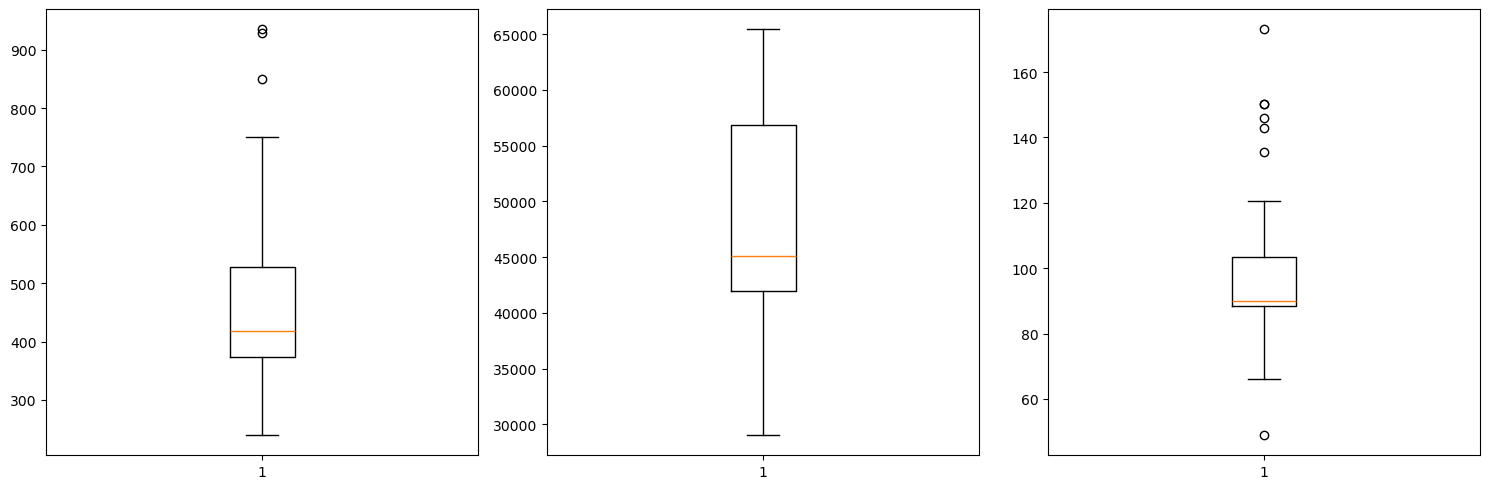

In [11]:
#用箱型图找出离群值
plot_list = ['总价(万)','单位价格(元/㎡)','面积(㎡)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(plot_list):
    axes[i].boxplot(info1[column]) 
plt.tight_layout()
plt.show()

由图像可知，总价有3个离群值在上方，单位价格无离群值，面积有很多离群值在上方。

### 2、租房网数据爬取-北京昌平霍营

In [12]:
#租房网：北京昌平霍营
url2="https://zu.fang.com/house-a012-b02697/"
driver.get(url2)

In [13]:
#因为只有一页，所以直接爬数据
string_list2=[]
table =driver.find_element('class name','houseList')
dls = table.find_elements(By.TAG_NAME, 'dl')
data = []
for dl in dls: 
    cells = dl.find_elements(By.TAG_NAME, 'dd')
    if cells:
        dl_data = [cell.text for cell in cells]
        data.append(dl_data)
df = pd.DataFrame(data)
string_list2.append(df)

In [14]:
#数据处理
string_list2 = pd.DataFrame(string_list2[0])
info2 = string_list2[0].str.split('\n', n=3, expand=True)

#分出月租价格并转换格式
info2[[3, '月租价格(元/月)']] = info2[3].str.rsplit('\n', n=1, expand=True)
info2['月租价格(元/月)'] = info2['月租价格(元/月)'].apply(lambda x:x[:-3]).astype('float')

#拆出m2数据并转换格式
info2[['出租方式','出租区域','面积(㎡)','朝向']] = info2[1].str.rsplit('|', n=3, expand=True)
info2['面积(㎡)'] = info2['面积(㎡)'].apply(lambda x:x[:-1]).astype('float')

#计算单位月租价格
info2['单位月租价格(元/月/㎡)'] = info2['月租价格(元/月)']/info2['面积(㎡)']

info2 = info2.drop(columns=[1])

info2.head()

,0,2,3,月租价格(元/月),出租方式,出租区域,面积(㎡),朝向,单位月租价格(元/月/㎡)
0,三旗百汇 龙旗广场 黄平路 育新地铁 免佣,昌平-霍营-新康园,距8号线育新站约730米。\n交通便利周边配套齐南北通透,1000.0,整租,3室1厅,65.0,朝东南,15.384615
1,免佣 可月付 霍营 回龙观东大街 旗胜家园精装修南北,昌平-霍营-旗胜家园,距13号线霍营站约521米。\n交通便利周边配套齐采光好,4000.0,整租,2室1厅,65.0,朝南北,61.538462
2,回龙观东大街 黄平路 农业农村干部管理学院,昌平-霍营-华龙苑中里,距8号线回龙观东大街站约782米。\n交通便利周边配套齐南北通透,1000.0,合租主卧,3户合租,16.0,朝南北,62.500000
3,"超值优惠! 华龙苑中里 2室,装修不错,有家具的!",昌平-霍营-华龙苑中里,距8号线回龙观东大街站约782米。\n首次出租南北通透,5200.0,整租,2室1厅,56.0,朝南,92.857143
4,合租·旗胜家园 3居室 北卧,昌平-霍营-旗胜家园,距13号线霍营站约521米。\n首次出租南北通透,1460.0,合租主卧,2户合租,8.0,朝北,182.500000


In [15]:
info2.describe()

,月租价格(元/月),面积(㎡),单位月租价格(元/月/㎡)
count,56.000000,56.000000,56.000000
mean,2898.571429,41.500000,89.343472
std,1729.882212,31.991476,36.151178
min,1000.000000,8.000000,10.000000
25%,1500.000000,16.000000,64.501404
50%,2000.000000,20.000000,92.582418
75%,4800.000000,66.250000,101.923077
max,6500.000000,120.000000,182.500000


离群值分析：

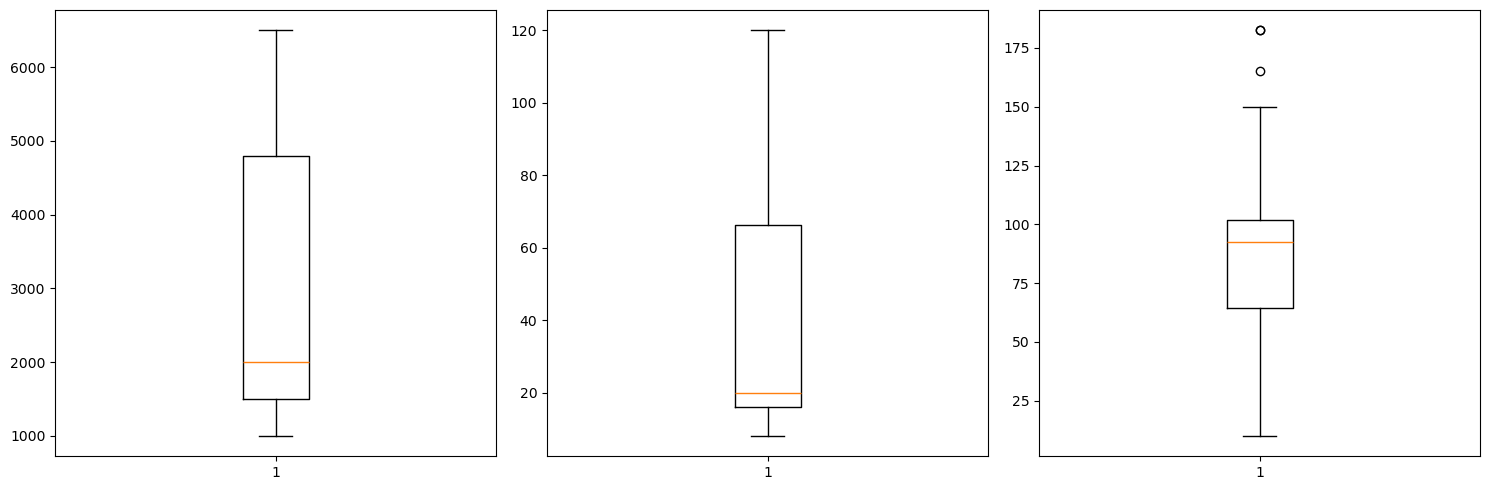

In [19]:
#用箱型图找出离群值
plot_list = ['月租价格(元/月)','面积(㎡)','单位月租价格(元/月/㎡)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(plot_list):
    axes[i].boxplot(info2[column]) 
plt.tight_layout()
plt.show()

由箱型图可知，月租价格无离群值，面积无离群值，单位月租价格有2个离群值在上方。

### 3、计算rent ratio

In [22]:
#按照每㎡计算rent ratio（房价租金比 = 房价中位数/年租金中位数）
rent_ratio = 45060/(92.582418*12)
print(rent_ratio)
# 组员爬取的沙河地区：
ratio1 = 56216.5000/(55.555556*12)
print(ratio1)

40.558456790359486
84.324749325402


组员计算的沙河的rent ratio是：84.324749325402

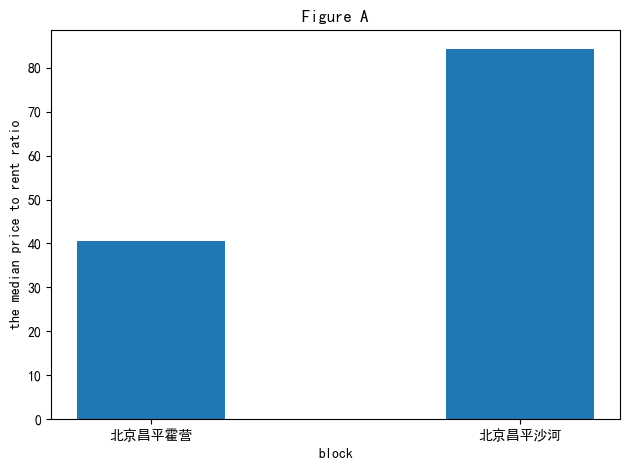

In [23]:
plt.rcParams['font.sans-serif']=['SimHei']
block_list = ['北京昌平霍营', '北京昌平沙河']
values = [40.558456790359486,84.324749325402]

# 绘制条形图
plt.bar(block_list, values,width = 0.4)
plt.title('Figure A') #标题
plt.xlabel('block') #横轴标签
plt.ylabel('the median price to rent ratio') #纵轴标签
plt.tight_layout()
plt.show()

### 4、跑回归
（1）模型1

In [24]:
#根据模型找出跑回归需要的数据
info_m1 = pd.DataFrame()
info_m1[['price','m2']] = info1[['单位价格(元/㎡)','面积(㎡)']]
info_m1['block'] = '北京昌平霍营'
info_m1.tail()
#导出数据给组员
info_m1.to_csv('霍营.csv',index=False)

In [25]:
#导入组员的数据
info_m1_2 = pd.read_csv('沙河.csv')
info_m1_2 = pd.DataFrame(info_m1_2)
#合并数据
info_m1 = pd.concat([info_m1,info_m1_2], ignore_index=True)
info_m1

,price,m2,block
0,64951.0,110.390000,北京昌平霍营
1,65434.0,142.890000,北京昌平霍营
2,42548.0,86.960000,北京昌平霍营
3,61756.0,110.110000,北京昌平霍营
4,63603.0,111.000000,北京昌平霍营
...,...,...,...
115,41709.0,563.427558,北京昌平沙河
116,36078.0,255.003049,北京昌平沙河
117,90452.0,497.501437,北京昌平沙河
118,29900.0,69.230769,北京昌平沙河


In [26]:
#把block变成哑变量
info_m1 = pd.get_dummies(info_m1,columns=['block'],drop_first=True,dtype=int)

In [27]:
print(info_m1)

       price          m2  block_北京昌平霍营
0    64951.0  110.390000             1
1    65434.0  142.890000             1
2    42548.0   86.960000             1
3    61756.0  110.110000             1
4    63603.0  111.000000             1
..       ...         ...           ...
115  41709.0  563.427558             0
116  36078.0  255.003049             0
117  90452.0  497.501437             0
118  29900.0   69.230769             0
119  36654.0   87.030065             0

[120 rows x 3 columns]


In [28]:
#根据模型跑回归
model1 = smf.ols(formula='price ~ m2 + block_北京昌平霍营 + m2:block_北京昌平霍营', data=info_m1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     13.39
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           1.45e-07
Time:                        12:38:52   Log-Likelihood:                -1326.9
No. Observations:                 120   AIC:                             2662.
Df Residuals:                     116   BIC:                             2673.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.394e+04   3749.835     

In [29]:
#构建需要预测的信息
predict_m1 = pd.DataFrame()

predict_m1[['m2','block_北京昌平霍营']]=[[50,1]]
predict_m1.loc[len(predict_m1.index)] = [50,0]
predict_m1.loc[len(predict_m1.index)] = [100,1]
predict_m1.loc[len(predict_m1.index)] = [100,0]
#进行预测
pre1_result = model1.predict(predict_m1)
pre1_result

0    44976.799415
1    37101.825315
2    48989.310958
3    40260.365523
dtype: float64

In [30]:
m1_result = pd.concat([predict_m1,pre1_result],axis=1)
m1_result.columns = ['m2','block','price/m2']
m1_result

,m2,block,price/m2
0,50,1,44976.799415
1,50,0,37101.825315
2,100,1,48989.310958
3,100,0,40260.365523


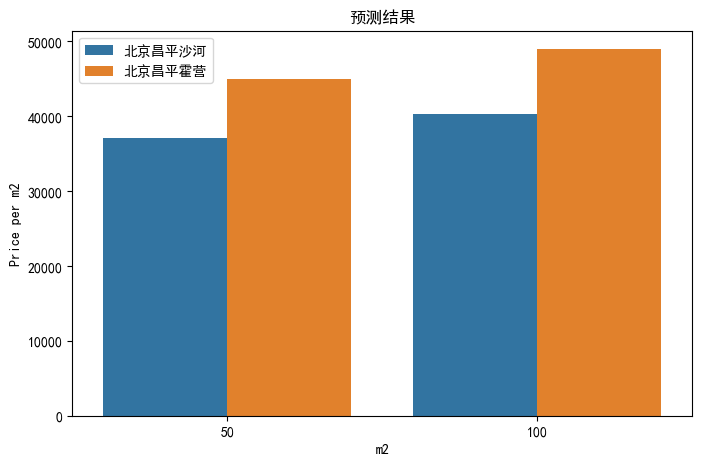

In [38]:
#画图看下预测结果
plt.figure(figsize=(8, 5))
plot_pre = sns.barplot(x='m2', y='price/m2', hue='block', data=m1_result)

plt.xlabel("m2")
plt.ylabel("Price per m2")
plt.title("预测结果")
handles, labels = plot_pre.get_legend_handles_labels()
plt.legend(handles,["北京昌平沙河", "北京昌平霍营"])
plt.show()

（2）模型2

In [32]:
#根据模型找出跑回归需要的数据
info_m2 = pd.DataFrame()
info_m2[['rent','m2']] = info2[['单位月租价格(元/月/㎡)','面积(㎡)']]
info_m2['block'] = '北京昌平霍营'
#导出数据给组员
info_m2.to_csv('霍营租金.csv',index=False)

In [33]:
#导入组员的数据
info_m2_2 = pd.read_csv('沙河租金.csv')
info_m2_2 = pd.DataFrame(info_m2_2)
#合并数据
info_m2 = pd.concat([info_m2,info_m2_2], ignore_index=True)

#把block变成哑变量
info_m2 = pd.get_dummies(info_m2,columns=['block'],drop_first=True,dtype=int)
info_m2

,rent,m2,block_北京昌平霍营
0,15.384615,65.0,1
1,61.538462,65.0,1
2,62.500000,16.0,1
3,92.857143,56.0,1
4,182.500000,8.0,1
...,...,...,...
111,35.714286,28.0,0
112,55.555556,18.0,0
113,55.555556,18.0,0
114,55.555556,18.0,0


In [34]:
#根据模型跑回归
model2 = smf.ols(formula='rent ~ m2 + block_北京昌平霍营 + m2:block_北京昌平霍营', data=info_m2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     59.72
Date:                Thu, 20 Mar 2025   Prob (F-statistic):           3.90e-23
Time:                        12:39:38   Log-Likelihood:                -505.79
No. Observations:                 116   AIC:                             1020.
Df Residuals:                     112   BIC:                             1031.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          57.6115      2.789     

In [35]:
#因为需要预测的信息一致，所以直接进行预测
pre2_result = model2.predict(predict_m1)
rr_result = pd.concat([pre1_result,pre2_result],axis=1,ignore_index=True)
rr_result.columns = ['price/m2','rent/m2']
rr_result['rent ratio'] = rr_result['price/m2']/(rr_result['rent/m2']*12)
rr_result

,price/m2,rent/m2,rent ratio
0,44976.799415,82.500854,45.430640
1,37101.825315,57.164380,54.086457
2,48989.310958,42.250163,96.625487
3,40260.365523,56.717237,59.153630


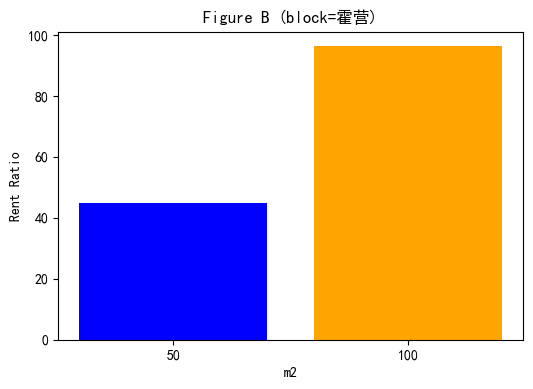

In [36]:
#霍营的预测结果
rr2 = pd.DataFrame({'m2': ['50', '100'], 'rent_ratio': [44.818283, 96.214985]})
# 画条形图
plt.figure(figsize=(6, 4))
plt.bar(rr2['m2'], rr2['rent_ratio'], color=['blue', 'orange'])
# 添加标签
plt.xlabel("m2")
plt.ylabel("Rent Ratio")
plt.title("Figure B (block=霍营)")

plt.show()

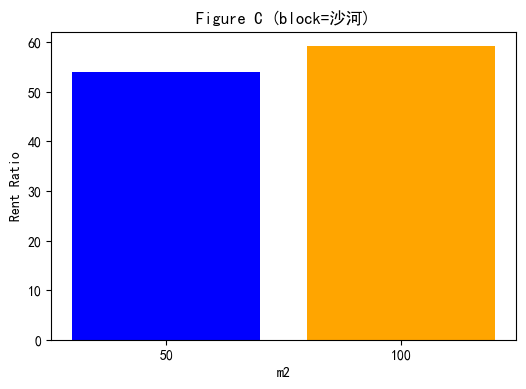

In [37]:
#沙河的预测结果
rr3 = pd.DataFrame({'m2': ['50', '100'], 'rent_ratio': [54.086457, 59.153630]})
# 画条形图
plt.figure(figsize=(6, 4))
plt.bar(rr3['m2'], rr3['rent_ratio'], color=['blue', 'orange'])
# 添加标签
plt.xlabel("m2")
plt.ylabel("Rent Ratio")
plt.title("Figure C (block=沙河)")

plt.show()